In [31]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [32]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [33]:
# Load datasets
dataset_path = '/kaggle/input/skin-data/data'  #dataset path
train_data = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform=transform)
val_data = datasets.ImageFolder(os.path.join(dataset_path, 'val'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [34]:
# Check class names
print(f"Classes: {train_data.classes}")

Classes: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']


In [35]:
train_dir = '/kaggle/input/skin-data/data/train'
diseases = os.listdir(train_dir)

In [36]:
# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
# Initialize model, loss, and optimizer
num_classes = len(train_data.classes)  # Automatically detects the number of classes
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize lists to track training/validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [39]:
# Training and Validation Loop
epochs = 20
for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracies.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

Epoch 1/20, Train Loss: 1.2267, Train Accuracy: 49.27%, Val Loss: 0.9833, Val Accuracy: 62.45%
Epoch 2/20, Train Loss: 0.7777, Train Accuracy: 70.29%, Val Loss: 0.7032, Val Accuracy: 72.59%
Epoch 3/20, Train Loss: 0.5017, Train Accuracy: 81.26%, Val Loss: 0.5353, Val Accuracy: 81.59%
Epoch 4/20, Train Loss: 0.3323, Train Accuracy: 88.54%, Val Loss: 0.4683, Val Accuracy: 84.83%
Epoch 5/20, Train Loss: 0.2065, Train Accuracy: 93.37%, Val Loss: 0.4242, Val Accuracy: 86.09%
Epoch 6/20, Train Loss: 0.1318, Train Accuracy: 95.42%, Val Loss: 0.4921, Val Accuracy: 85.36%
Epoch 7/20, Train Loss: 0.0914, Train Accuracy: 97.19%, Val Loss: 0.4737, Val Accuracy: 85.56%
Epoch 8/20, Train Loss: 0.0672, Train Accuracy: 97.93%, Val Loss: 0.5424, Val Accuracy: 86.82%
Epoch 9/20, Train Loss: 0.0414, Train Accuracy: 98.80%, Val Loss: 0.5341, Val Accuracy: 86.30%
Epoch 10/20, Train Loss: 0.0706, Train Accuracy: 97.87%, Val Loss: 0.5931, Val Accuracy: 85.15%
Epoch 11/20, Train Loss: 0.0266, Train Accuracy: 

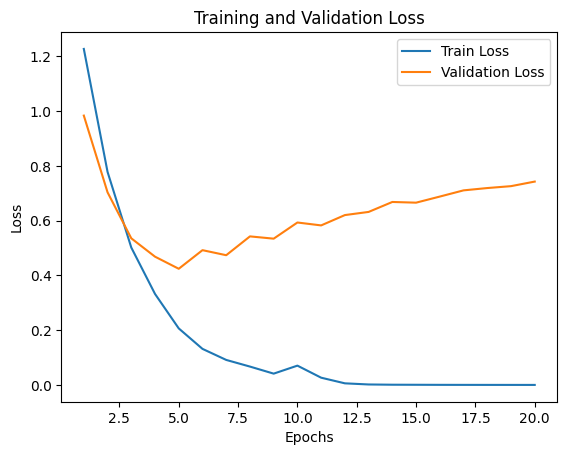

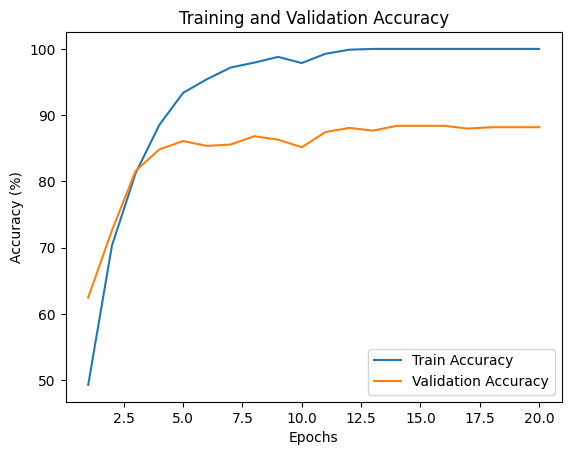

In [40]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [41]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
batch_size = 32
test_dir = "../input/skin-data/data/test"
test = ImageFolder(test_dir, transform=transform)
test_dl = DataLoader(test, batch_size, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

Test Loss: 0.6324, Test Accuracy: 0.9049
Confusion Matrix:
[[237  10   6   0   0]
 [ 10 294   9   2   2]
 [  3  17 172   1   8]
 [  0   3   8 102   2]
 [  0   5   5   0  60]]


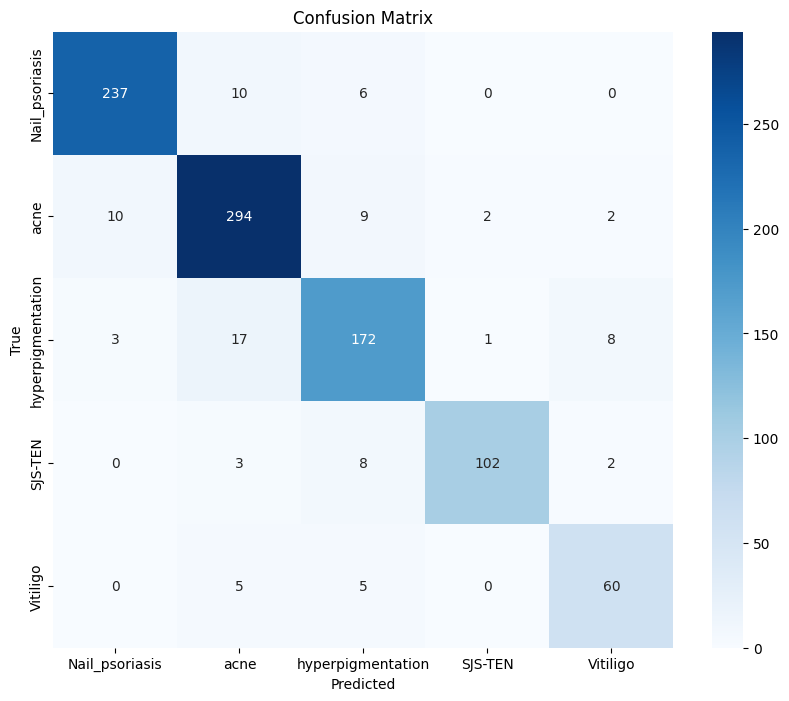

Classification Report:
                   precision    recall  f1-score   support

   Nail_psoriasis       0.95      0.94      0.94       253
             acne       0.89      0.93      0.91       317
hyperpigmentation       0.86      0.86      0.86       201
          SJS-TEN       0.97      0.89      0.93       115
         Vitiligo       0.83      0.86      0.85        70

         accuracy                           0.90       956
        macro avg       0.90      0.89      0.90       956
     weighted avg       0.91      0.90      0.90       956



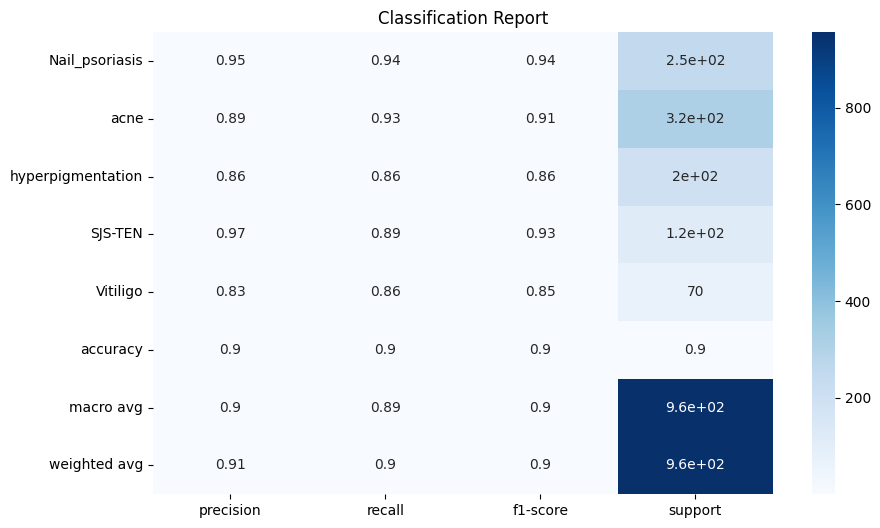

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model on the GPU
model.eval()
with torch.no_grad():
    all_true_labels = []
    all_predicted_labels = []

    total_loss = 0
    total_accuracy = 0

    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        test_outputs = model(images)
        test_loss = F.cross_entropy(test_outputs, labels)  # Calculate loss
        total_loss += test_loss.item()

        accuracy = (test_outputs.argmax(dim=1) == labels).float().mean()
        total_accuracy += accuracy.item()

        # Collect predictions and true labels for confusion matrix
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(test_outputs.argmax(dim=1).cpu().numpy())
    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_dl)
    avg_accuracy = total_accuracy / len(test_dl)

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_accuracy:.4f}')
    # Convert to numpy arrays for further analysis
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=diseases, yticklabels=diseases)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    class_report = classification_report(all_true_labels, all_predicted_labels, target_names=diseases)
    print("Classification Report:")
    print(class_report)

    # Plot classification report
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame.from_dict(classification_report(all_true_labels, all_predicted_labels, target_names=diseases, output_dict=True)).T, annot=True, cmap='Blues')
    plt.title('Classification Report')
    plt.show()